# Ramp Relaxation Test Analysis 
28/04/25 - Fraser Shields 

This script loops through csv files created by TA 5500 when performing mechanical tests and plots the relevant stress vs time, strain vs time, and stress vs strain plots. Ramp, relaxation and dynamics moduli are extracted from the data, alongside peak stress and relaxation time. 

## Extract and Plot

In [1]:
import pandas as pd

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.pyplot import subplots

import seaborn as sns

import pathlib
from pathlib import Path

import math

import scipy
from scipy.signal import savgol_filter

Text(0.5, 0, 'Time (s)')

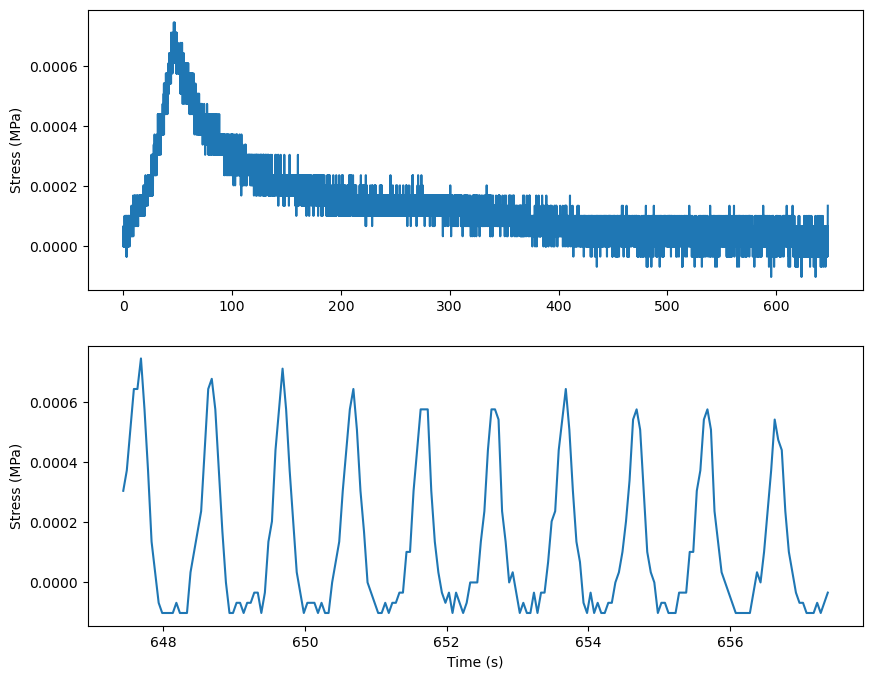

In [19]:
filename = '137algd28 03082024 070526_tdf.csv'

folder_path = r'C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Primary\Mechanical testing\raw_data'
file_path = Path(folder_path) / filename

# extract df from csv file
raw_df = pd.read_csv(file_path, skiprows=48, usecols=range(1,4))

# drop row containing units
raw_df = raw_df.drop(0)

# reset index after dropping
raw_df = raw_df.reset_index(drop=True)

# convert data to float 
raw_df = raw_df.astype(float)

# define sample dimensions
thickness = 2.37 # mm
diameter = 6.13 # mm
area = math.pi * (diameter / 2)**2 

# calculate stress and strain 
raw_df['Stress'] = - raw_df['Load 3'] / area
raw_df['Strain'] = - raw_df['Disp'] / thickness

# split ramp relaxation and dynamic data
# first need to calculate relaxation and dynamic start times
strain_rate = 0.01 # mm/s 
t_relax_start = (thickness * 0.2) / strain_rate
t_dyn_start = t_relax_start + 600

# create filtered df with ramp-relaxation and dynamic data
ramp_rel_df = raw_df[(raw_df['Elapsed Time'] <= t_dyn_start)].copy()

dyn_df = raw_df[(raw_df['Elapsed Time'] >= t_dyn_start) & (raw_df['Elapsed Time'] <= t_dyn_start + 10)].copy()

# plot seperated portions of data
fig, axs = subplots(nrows=2, ncols=1, figsize=(10, 8))

axs[0].plot(ramp_rel_df['Elapsed Time'], ramp_rel_df['Stress'])
axs[0].set_ylabel('Stress (MPa)')

axs[1].plot(dyn_df['Elapsed Time'], dyn_df['Stress'])
axs[1].set_ylabel('Stress (MPa)')
axs[1].set_xlabel('Time (s)')


Text(0.5, 0, 'Time (s)')

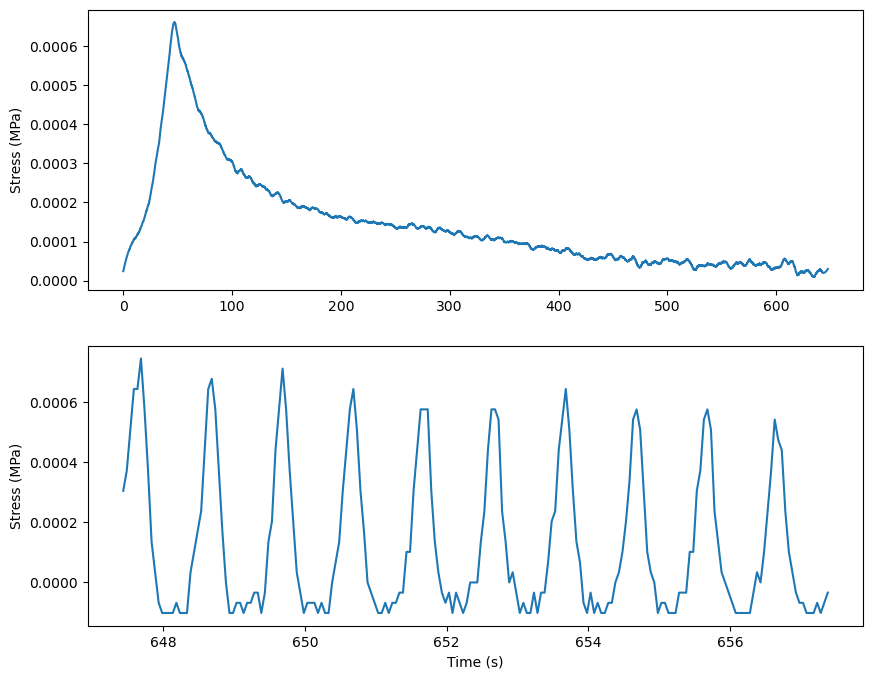

In [20]:
# smooth ramp data 
ramp_rel_df['Stress_smooth'] = savgol_filter(ramp_rel_df['Stress'], 200, 2)

# plot seperated portions of data
fig, axs = subplots(nrows=2, ncols=1, figsize=(10, 8))

axs[0].plot(ramp_rel_df['Elapsed Time'], ramp_rel_df['Stress_smooth'])
axs[0].set_ylabel('Stress (MPa)')

axs[1].plot(dyn_df['Elapsed Time'], dyn_df['Stress'])
axs[1].set_ylabel('Stress (MPa)')
axs[1].set_xlabel('Time (s)')

## Ramp Relaxation Phase Analysis

2.993628077804919
0.00037271927679203946
80.6328
33.2328


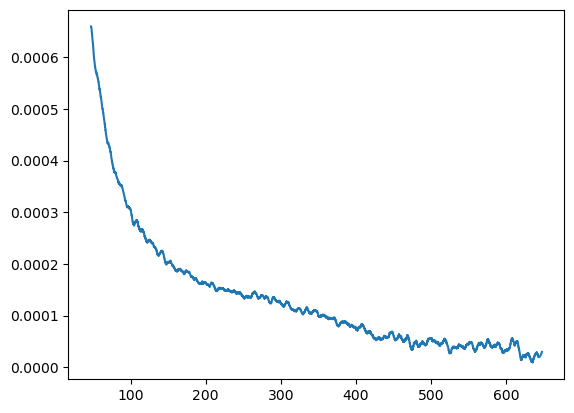

In [ ]:
## find peak stress
peak_stress = max(ramp_rel_df['Stress'])


## find secant modulus from 5% to 15%
strain_low = 0.05
strain_high = 0.15

# find idx for above strains
idx_low = (ramp_rel_df['Strain'] - strain_low).abs().idxmin()
idx_high = (ramp_rel_df['Strain'] - strain_high).abs().idxmin()

# find corresponding stress values
stress_low = ramp_rel_df.loc[idx_low, 'Stress_smooth']
stress_high = ramp_rel_df.loc[idx_high, 'Stress_smooth']

# calculate secant modulus
secant_modulus = (stress_high - stress_low) / (strain_high - strain_low)

print(secant_modulus*1000)


## find equilibrium modulus
# extract last 30 seconds of relaxation phase as equilibrium region
equil_region_df = ramp_rel_df[(ramp_rel_df['Elapsed Time'] >= t_dyn_start-60) & (ramp_rel_df['Elapsed Time'] <= t_dyn_start)].copy()

# find average stress over equilibrium region
equil_stress = equil_region_df['Stress'].mean()

equil_modulus = equil_stress / 0.2 

## find relaxation time 
# extract relaxation region
relax_region_df = ramp_rel_df[(ramp_rel_df['Elapsed Time'] <= t_dyn_start) & (ramp_rel_df['Elapsed Time'] >= t_relax_start)].copy()

plt.plot(relax_region_df['Elapsed Time'], relax_region_df['Stress_smooth'])

# define 50% stress 
stress_50 = peak_stress * 0.5 
print(stress_50)

# create boolean mask wehere stress is lesss than 50% of peak
mask_50 = relax_region_df['Stress_smooth'] <= stress_50

# find max indx of mask to get first instance stress goes below 50%
idx_50 = np.argmax(mask_50.values)

# find time from peak stress to 50% peak stress

t_50 = relax_region_df.iloc[idx_50]['Elapsed Time']
t_relax =  t_50 - t_relax_start
